# <font color='darkblue'> Sparkify Project Workspace - Small Dataset</font>

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## <font color='blue'>Set Environment</font>

In [1]:
# import neccessary libraries and packages

import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, split,
    first, last, 
    desc, asc,
    avg,
    count, countDistinct, approx_count_distinct,
    when, 
    isnull, isnan,
    from_unixtime, date_format, datediff,
    dayofmonth, month, hour, to_date,
    )

# libraries and packages for modeling

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.feature import (
    OneHotEncoder, 
    OneHotEncoderModel
)

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("SparkifySmallData")
        .getOrCreate())

sc = spark.sparkContext
sc.setLogLevel("WARN")

21/12/23 17:28:20 WARN Utils: Your hostname, greg resolves to a loopback address: 127.0.1.1; using 192.168.0.21 instead (on interface wlp82s0)
21/12/23 17:28:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/23 17:28:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# create a path variable for the minidataset file
mini_path = "data/mini_sparkify_event_data.json"

## <font color='blue'>Load and Clean Dataset</font>

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    
    return df


In [5]:
def clean_data(df):
    """
    Performs basic cleaning operations on the raw data.def load_data(file_path):
        - removes entries with missing userId
        - split the location column in two columns: city and state
        - parses timestamp columns
    
    INPUT:
            (PySpark dataframe) - dataframe of raw data
    OUTPUT:
            (PySpark dataframe) - dataframe of cleaned data
    """
    
    # print message to indicate the start of the process
    print("Cleaning the data ...")
    
    # print a count of rows before cleaning
    initial_records = df.count()
    print("Dataset has {} rows initially.".format(initial_records))
    
    # filter out all the records without userId
    df = df.filter(df.userId != "")
    
    # split the location column in two columns: city and state
    df = df.withColumn("city", split(df["location"], ",").getItem(0)) \
           .withColumn("state", split(df["location"], ",").getItem(1))

    # drop the location column
    df.drop(df.location)
    
    # parse the timestamp columns: registration and ts
    df = df.withColumn("event_ts", from_unixtime(col("ts")/1000.0))
    df = df.withColumn("reg_ts", from_unixtime(col("registration")/1000.0))
    
    # print end of process message
    print("Finished cleaning the data ...")
    
    # print a count of rows after cleaning
    removed_rows = initial_records - df.count()
    print("Cleaned dataset has {} rows, {} rows were removed". \
        format(df.count(), initial_records - df.count()))
    
    return df
    

In [6]:
# read the mini dataset
mini_sparkify = load_data(mini_path)
# clean the mini dataset
df = clean_data(mini_sparkify)

Loading the dataset ...


Cleaning the data ...
Dataset has 286500 rows initially.
Finished cleaning the data ...
Cleaned dataset has 278154 rows, 8346 rows were removed


In [7]:
# save to storage level 'MEMORY_AND_DISK'
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, city: string, state: string, event_ts: string, reg_ts: string]

## <font color='blue'>Preprocess Dataset</font>

In [8]:
def preprocess_data(df):
    
    """
    Prepare the data for modeling via creating several features.
     - firstevent_ts (timestamp) - first time an user is active
     - lastevent_ts (timestamp) - last time an user is active
     - date_ts (date type) - date from timestamp
     - date_reg (timestamp) - registration date
     - init_days_interv (int) - days between registration and first activity
     - tenure_days_interv (int) - days between registration and last activity
     - active_days (int) - days the user has some activity on the platform
     - session_h (float) - session's duration in hours
     
     INPUT:
         df (PySpark dataframe) - cleaned dataframe
     OUTPUT:
         df (PySpark dataframe) - dataframe with the listed features added
    """
    
    # create window: data grouped by userId, time ordered     
    win_user = (W.partitionBy("userId")
            .orderBy("event_ts")
            .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))
    # create window: data grouped by sessionId and userId, time ordered
    win_user_session = (W.partitionBy("sessionId", "userId")
                    .orderBy("event_ts")
                    .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))
    
    # record the first time an user is active
    df = df.withColumn("firstevent_ts", first(col("event_ts")).over(win_user))
    # record the last time an user is active
    df = df.withColumn("lastevent_ts", last(col("event_ts")).over(win_user))

    # extract date from "ts" record
    df = df.withColumn("date_ts",to_date("event_ts")) 
    # extract "registration" date
    df = df.withColumn("date_reg",to_date("reg_ts")) 

    # warmup time = registration time to first event in days
    df = df.withColumn("init_days_interv", datediff(col("firstevent_ts"), col("reg_ts")))
    # tenure time = registration time to last event in days
    df = df.withColumn("tenure_days_interv", datediff(col("lastevent_ts"), col("reg_ts")))
    # active time =  days between the first event and the last event 
    df = df.withColumn("active_days", approx_count_distinct(col("date_ts")).over(win_user))

    # create column that records the individual session's duration in hours
    df = df.withColumn("session_h",
                     (last(df.ts).over(win_user_session) - first(df.ts) \
                      .over(win_user_session))/(1000*3600))  
    
    return df

In [9]:
# preprocess mini dataset
df_proc = preprocess_data(df)

In [10]:
# the features in the preprocessed dataframe
df_proc.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- event_ts: string (nullable = true)
 |-- reg_ts: string (nullable = true)
 |-- firstevent_ts: string (nullable = true)
 |-- lastevent_ts: string (nullable = true)
 |-- date_ts: date (nullable = true)
 |-- date_reg: date (nullable

## <font color='blue'>Feature Engineering</font>

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [11]:
def build_features(df):
    
    """
    Feature engineering to be used in modelling.
    - nr_songs (int) - total number of songs user listened to
    - nr_likes (int) - total number of "Thumbs Up" of the user
    - nr_dislikes (int) - total number of "Thumbs Down" of the user
    - nr_playlist (int) - number of songs added to the playlist
    - nr_friends (int) - number of friends added through "Add Friend"
    - nr_downgrades (int) - total number of visits to "Downgrade" page by the user
    - nr_upgrades (int) - total number of visits to "Upgrade" page by the user
    - nr_home (int) - total number of visits to "Home" page by the user
    - nr_error (int) - total number of errors encountered by the user
    - nr_settings (int) - total number of visits to "Settings" page by the user
    - nr_ads (int) - total number of ads the user got
    - nr_sessions (int) - number of sessions of the user
    - n_acts (int) - total number of actions taken by the user
    - avg_sess_h (float) - average session length in hours
    - acts_per_session (float) - average number of actions per session for the user
    - songs_per_session (float) - average numer of songs listened per session by the user
    - ads_per_session (float) - average number of ads per session, received by user
    - init_days_interv (int) - time interval in days from registration to the first action of the user
    - tenure_days_interv (int) - time interval in days from registration to the last action of the user
    - active_days (int) - number of days the user was active on the platform
    
    - gender (binary) - 1 for F (female), 0 for M (male)
    - level (binary) - 1 for paid, 0 for free
    - downgrade (binary) - 1 for "Submit Downgrade" page visit, 0 otherwise 
    - churn (binary) - 1 for "CAncellation Confirmation" page visit, 0 otherwise
    
    INPUT:
        df (PySpark dataframe) - preprocessed dataframe
        df_feats (PySpark datafrane) - dataframe that contains engineered features
    """
    
    df_feats = df.groupBy("userId") \
        .agg(
    
            # count user's individual actions using all page visits
    
            count(when(col("page") == "NextSong", True)).alias("nr_songs"),
    
            count(when(col("page") == "Thumbs Up", True)).alias("nr_likes"),
            count(when(col("page") == "Thumbs Down", True)).alias("nr_dislikes"),
    
            count(when(col("page") == "Add to Playlist", True)).alias("nr_playlist"),
            count(when(col("page") == "Add Friend", True)).alias("nr_friends"),
    
            count(when(col("page") == "Downgrade", True)).alias("nr_downgrades"),
            count(when(col("page") == "Upgrade", True)).alias("nr_upgrades"),
    
            count(when(col("page") == "Home", True)).alias("nr_home"),
            count(when(col("page") == "Error", True)).alias("nr_error"),
            count(when(col("page") == "Settings", True)).alias("nr_settings"),
    
            count(when(col("page") == "Roll Advert", True)).alias("nr_ads"),
    
            # compute the number of sessions a user is in
            countDistinct("sessionId").alias("nr_sessions"),
    
            # find the total number of actions a user took
            countDistinct("itemInSession").alias("n_acts"),
    
            # compute the average session length in hours
            avg(col("session_h")).alias("avg_sess_h"),
    
            # compute the average number of page actions per sesssion
            (countDistinct("itemInSession")/countDistinct("sessionId")).alias("acts_per_session"),
    
            # compute the average number of songs per session
            (count(when(col("page") == "NextSong",
                        True))/countDistinct("sessionId")).alias("songs_per_session"),
    
            # compute the average number of ads per session
             (count(when(col("page") == "Roll Advert",
                         True))/countDistinct("sessionId")).alias("ads_per_session"),
        
            # days between registration and first activity
            first(col("init_days_interv")).alias("init_days_interv"),
            # the tenure time on the platform: from registration to last event in days
            first(col("tenure_days_interv")).alias("tenure_days_interv"),
            # number of days user visited the platform  
            first(col("active_days")).alias("active_days"),
    
            # encode the gender 1 for F and 0 for M
            first(when(col("gender") == "F", 1).otherwise(0)).alias("gender"),
    
            # encode the level (paid/free) according to the last record
            last(when(col("level") == "paid", 1).otherwise(0)).alias("level"),
    
            # flag those users that downgraded 
            last(when(col("page") == "Downgrade", 1).otherwise(0)).alias("downgrade"),
    
            # create the churn column that records if the user cancelled 
            last(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn"),
            )
    # drop the column "userId" 
    df_feats = df_feats.drop("userId")       
    
    return df_feats

In [12]:
# build the features dataframe for mini dataset
df_feats = build_features(df_proc)
df_feats.printSchema()

root
 |-- nr_songs: long (nullable = false)
 |-- nr_likes: long (nullable = false)
 |-- nr_dislikes: long (nullable = false)
 |-- nr_playlist: long (nullable = false)
 |-- nr_friends: long (nullable = false)
 |-- nr_downgrades: long (nullable = false)
 |-- nr_upgrades: long (nullable = false)
 |-- nr_home: long (nullable = false)
 |-- nr_error: long (nullable = false)
 |-- nr_settings: long (nullable = false)
 |-- nr_ads: long (nullable = false)
 |-- nr_sessions: long (nullable = false)
 |-- n_acts: long (nullable = false)
 |-- avg_sess_h: double (nullable = true)
 |-- acts_per_session: double (nullable = true)
 |-- songs_per_session: double (nullable = true)
 |-- ads_per_session: double (nullable = true)
 |-- init_days_interv: integer (nullable = true)
 |-- tenure_days_interv: integer (nullable = true)
 |-- active_days: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- churn: integer (null

### <font color='blue'>Investigate missing and null values</font>

In [13]:
# count null and nan values in each column
df_feats.select([count(when(isnan(c) | col(c).isNull(), c)) \
           .alias(c) for c in df_feats.columns]) \
           .show(vertical=True)

21/12/23 17:28:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-----------------
 nr_songs           | 0   
 nr_likes           | 0   
 nr_dislikes        | 0   
 nr_playlist        | 0   
 nr_friends         | 0   
 nr_downgrades      | 0   
 nr_upgrades        | 0   
 nr_home            | 0   
 nr_error           | 0   
 nr_settings        | 0   
 nr_ads             | 0   
 nr_sessions        | 0   
 n_acts             | 0   
 avg_sess_h         | 0   
 acts_per_session   | 0   
 songs_per_session  | 0   
 ads_per_session    | 0   
 init_days_interv   | 0   
 tenure_days_interv | 0   
 active_days        | 0   
 gender             | 0   
 level              | 0   
 downgrade          | 0   
 churn              | 0   



## <font color='blue'>Exploratory Data Analysis on Engineered Features</font>

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### <font color='blue'>Distribution of Churn on Gender</font>

In [14]:
# counts of churn/non_churn users grouped by gender
df_feats.crosstab("churn", "gender").sort("churn_gender").show()

+------------+---+---+
|churn_gender|  0|  1|
+------------+---+---+
|           0| 89| 84|
|           1| 32| 20|
+------------+---+---+



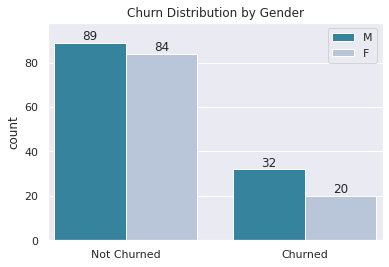

In [15]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(6,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.countplot(x="churn", data=df_feats.toPandas(), hue="gender",
                  palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container)
ax.set(xticklabels =["Not Churned", "Churned"])
ax.legend(labels=["M", "F"])
plt.xlabel("")

# create title
plt.title("Churn Distribution by Gender");


### <font color='blue'>Distribution of Churn on Level</font>

In [16]:
# counts of churn/non_churn users grouped by level
df_feats.crosstab("churn", "level").sort("churn_level").show()

+-----------+---+---+
|churn_level|  0|  1|
+-----------+---+---+
|          0| 59|114|
|          1| 21| 31|
+-----------+---+---+



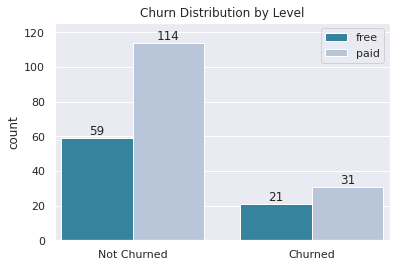

In [17]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(6,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.countplot(x="churn", data=df_feats.toPandas(), hue="level",
                  palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container)
ax.set(xticklabels =["Not Churned", "Churned"])
ax.legend(labels=["free", "paid"])
plt.xlabel("")

# create title
plt.title("Churn Distribution by Level");

### <font color='blue'>Songs per Session for Churn and Not Churned</font>

In [19]:
# display statistics for songs played per session
df_feats.describe("songs_per_session").show()

+-------+-----------------+
|summary|songs_per_session|
+-------+-----------------+
|  count|              225|
|   mean| 69.0023306588992|
| stddev|42.32095423081715|
|    min|              3.0|
|    max|286.6666666666667|
+-------+-----------------+



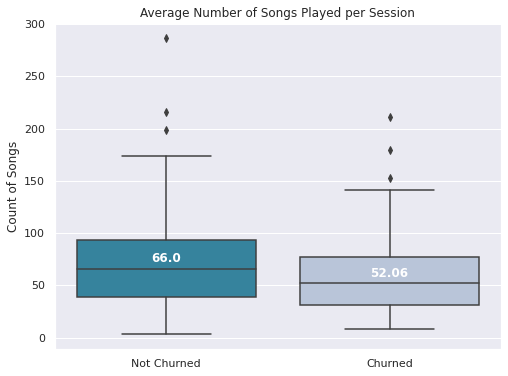

In [20]:
# adding labels to medians from:
# https://pretagteam.com/question/labeling-boxplot-in-seaborn-with-median-value

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,6)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'songs_per_session', 
                 data = df_feats.toPandas(),
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_feats.toPandas().groupby(['churn'])['songs_per_session'].median(), 2)
vertical_offset = df_feats.toPandas()['songs_per_session'].median() * 0.1 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Songs Played per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Count of Songs");

### <font color='blue'>Actions per Session for Churn and Not Churned</font>

In [21]:
# display statistics for actions played per session
df_feats.describe("acts_per_session").show()

+-------+------------------+
|summary|  acts_per_session|
+-------+------------------+
|  count|               225|
|   mean|31.053040008799456|
| stddev|32.154811754538564|
|    min|3.6315789473684212|
|    max|             259.0|
+-------+------------------+



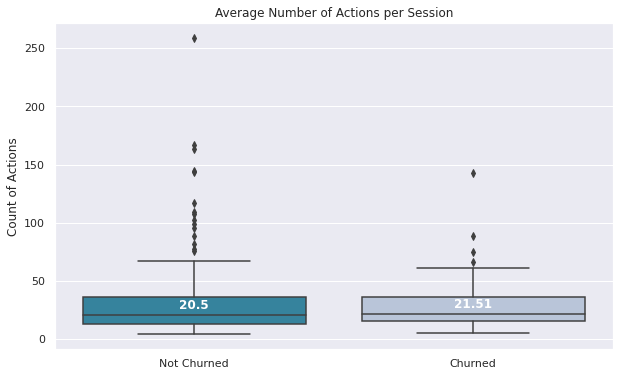

In [22]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'acts_per_session', 
                 data = df_feats.toPandas(),
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_feats.toPandas().groupby(['churn'])['acts_per_session'].median(), 2)
vertical_offset = df_feats.toPandas()['acts_per_session'].median() * 0.25 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Actions per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Count of Actions");

### <font color='blue'>Received Ads per Session for Churn and Not Churned</font>

In [23]:
# display statistics for average number of ads received per session
df_feats.describe("ads_per_session").show()

+-------+------------------+
|summary|   ads_per_session|
+-------+------------------+
|  count|               225|
|   mean|1.6459133170325297|
| stddev|1.7879873057253297|
|    min|               0.0|
|    max|              14.0|
+-------+------------------+



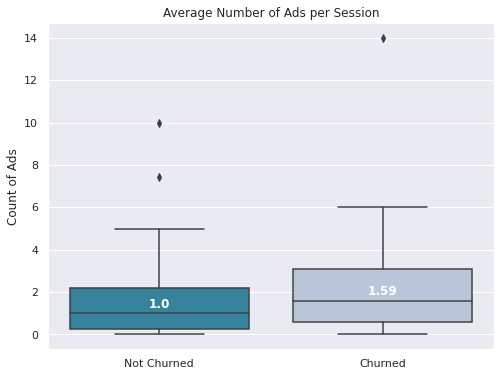

In [24]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,6)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'ads_per_session', 
                 data = df_feats.toPandas(),
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_feats.toPandas().groupby(['churn'])['ads_per_session'].median(), 2)
vertical_offset = df_feats.toPandas()['ads_per_session'].median() * 0.25 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Ads per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Count of Ads");

### <font color='blue'>Likes, Dislikes, Upgrades and Downgrades vs. Churn</font>

In [25]:
# statistics for the four features
df_feats.describe(["nr_likes", "nr_dislikes", "nr_upgrades", "nr_downgrades"]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|          nr_likes|       nr_dislikes|       nr_upgrades|     nr_downgrades|
+-------+------------------+------------------+------------------+------------------+
|  count|               225|               225|               225|               225|
|   mean|55.782222222222224|11.315555555555555|2.2177777777777776| 9.133333333333333|
| stddev| 65.47792460907043|13.077481251105503|2.5585369082956606|11.734412152785014|
|    min|                 0|                 0|                 0|                 0|
|    max|               437|                75|                15|                73|
+-------+------------------+------------------+------------------+------------------+



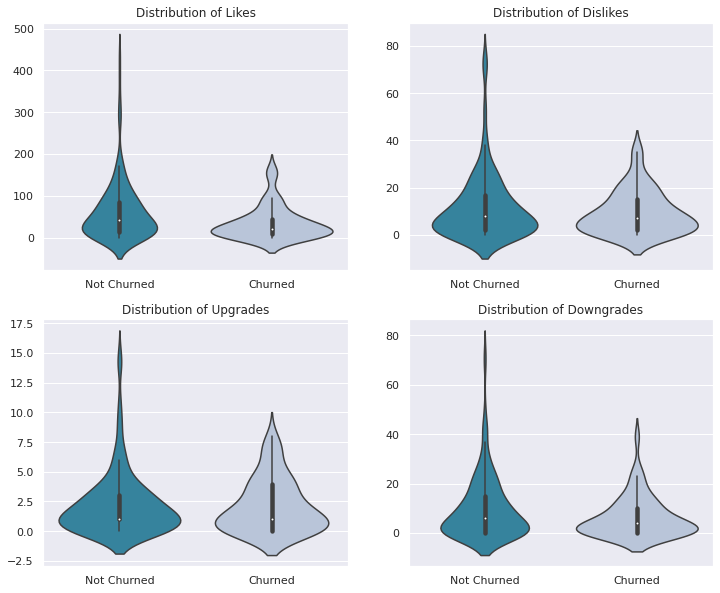

In [26]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

# tick labels for x-axis
xticklabels = ['Not Churned', 'Churned'];

# plot on first row on left
plt.subplot(2,2,1)
ax1=sns.violinplot(data=df_feats.toPandas(), x="churn", y="nr_likes",  palette='PuBuGn_r');

plt.title("Distribution of Likes");
plt.xlabel("")
plt.ylabel("");
ax1.set_xticks([0, 1])
ax1.set_xticklabels(xticklabels);

# plot on first row on right
plt.subplot(2,2,2)
ax2=sns.violinplot(data=df_feats.toPandas(), x="churn", y="nr_dislikes", palette='PuBuGn_r');

plt.title("Distribution of Dislikes");
plt.xlabel("")
plt.ylabel("");
ax2.set_xticks([0, 1])
ax2.set_xticklabels(xticklabels);

# plot on second row on left
plt.subplot(2,2,3)
ax3=sns.violinplot(data=df_feats.toPandas(), x='churn', y='nr_upgrades', palette='PuBuGn_r');

plt.title("Distribution of Upgrades");
plt.xlabel("")
plt.ylabel("");
ax3.set_xticks([0, 1])
ax3.set_xticklabels(xticklabels);

# plot on second row on right
plt.subplot(2,2,4)
ax4=sns.violinplot(data=df_feats.toPandas(), x="churn", y='nr_downgrades', palette='PuBuGn_r');

plt.title("Distribution of Downgrades");
plt.xlabel("")
plt.ylabel("");
ax4.set_xticks([0, 1])
ax4.set_xticklabels(xticklabels);

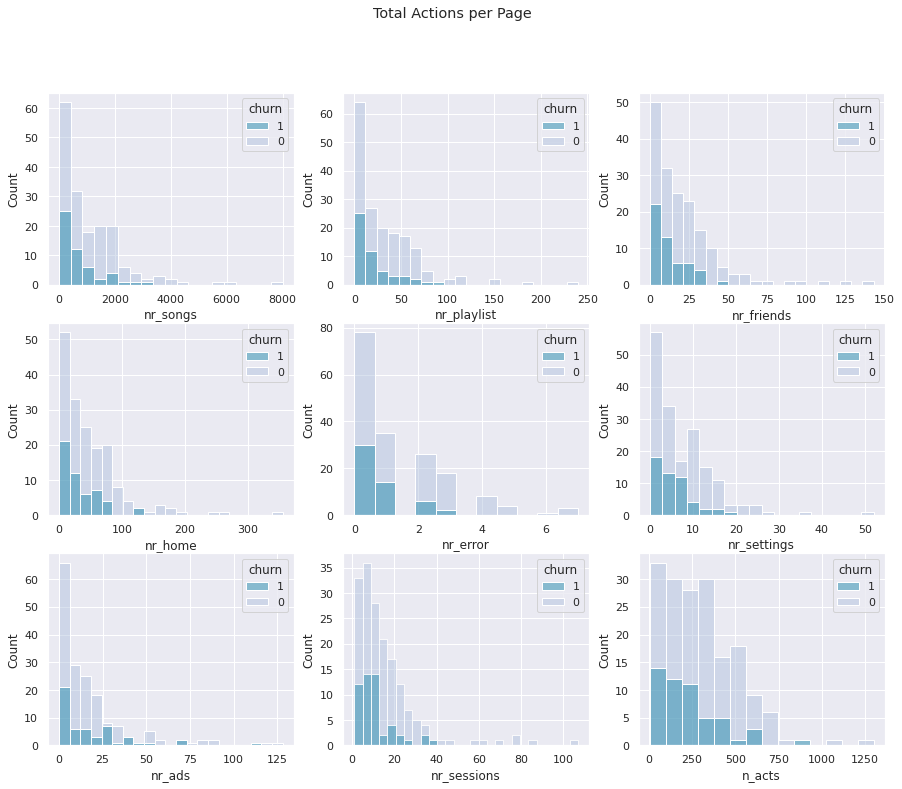

In [27]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,14)})
sns.set(font_scale=1)

# choose the individual plots figure properties
ncols = 3
nrows = 3
figsize = (ncols * 5, nrows * 4)

# assign fig and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Total Actions per Page")

# data as pandas dataframe
data = df_feats.select("churn", "nr_songs", "nr_playlist", "nr_friends", 
                       "nr_home", "nr_error", "nr_settings",
                       "nr_ads", "nr_sessions", "n_acts").toPandas()


# list of columns to plot
ylabels = data.columns[1:]

# create a loop to plot each column
for i, y in enumerate(ylabels):
    sns.histplot(ax=axes[divmod(i, ncols)], data=data, x=y, hue="churn", 
                 hue_order=[1,0],  palette='PuBuGn_r')

### <font color='blue'>Feature Relevance</font>

In [28]:
def median_diff(df, col, bincol):
    
    """
    Given the values in a column, computes the normalized difference between the medians 
    of the subsets based on values in a categorical column.
    
    INPUT:
        df (Pandas dataframe) - dataframe that contains both columns
        col (Pandas series) - column in df, of integer, float type
        bincol (Pandas series) - column in df, with entries 0, 1
    OUTPUT:
        dictionary: key = nd_col, value = normalized_diff
    """
    median_one = abs(df[df[bincol]==1][col].median())
    median_zero = abs(df[df[bincol]==0][col].median())
    normalized_difference = (median_zero - median_one)/max(median_zero, median_one)
    return {"column": f"nd_{col}",
            "normal_diff": normalized_difference}    

In [29]:
# list of numerical columns to investigate
num_cols = df_feats.toPandas().columns[:20]

# create a Pandas dataframe with the normalized median differences
df_medians = pd.DataFrame(list(map(lambda col: median_diff(df_feats.toPandas(), col, "churn"), num_cols)))
df_medians = df_medians.sort_values(["normal_diff"], ascending = False).reset_index(drop = True)

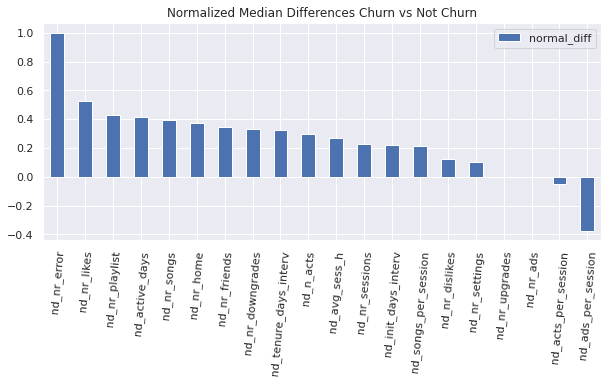

In [30]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(10,4)})

sns.set(font_scale=1)
ax = df_medians.plot.bar(x='column', y='normal_diff', rot=85)

# create title and labels
plt.title("Normalized Median Differences Churn vs Not Churn")
ax.set_xlabel("");
ax.set_ylabel("");

## <font color='blue'>Modeling</font>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### <font color='blue'>Split the Data</font>



In [31]:
SPLIT_VALS = [.7, .3]

# split the data into train and test sets

def split_data (df):
    
    """
    Split the dataset into training set and test set.
    """
    train_set, test_set = df.randomSplit(SPLIT_VALS,seed=1234)
    
    return train_set, test_set

### <font color='blue'>Build Pipeline</font>

In [32]:
# split the features and the label
CAT_FEATURES = ["gender", "level", "downgrade"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_playlist", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_home", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "avg_sess_h", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"


def build_pipeline(classifier):
    """
    Combines all the stages of the processing data. 
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the model to the pipeline
    stages += [classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

### <font color='blue'>Build Individual ML Pipelines</font>

In [ ]:
# train a Logistic Regression model
def logistic_regression_pipeline():
    lr_classifier = LogisticRegression(labelCol = "label",
                                       featuresCol = "features")
    return build_pipeline(lr_classifier)

# train a Decision Tree model
def decision_tree_pipeline():
    dt_classifier = DecisionTreeClassifier(labelCol = "label",
                                           featuresCol = "features",
                                           seed=1234)
    return build_pipeline(dt_classifier)

# train a Random Forest model
def random_forest_pipeline():
    rf_classifier = RandomForestClassifier(labelCol = "label",
                                           featuresCol = "features", 
                                           seed=1234)
    return build_pipeline(rf_classifier)

# train a Gradient-boosted Tree model
def gradient_boosted_pipeline():
    gbt_classifier = GBTClassifier(labelCol = "label",
                                   featuresCol = "features",
                                   seed=1234)
    return build_pipeline(gbt_classifier)

# train a Multilayer Perceptron Classifier
def multilayer_perceptron_pipeline():
    # specify layers: 23 (features), two intermediate (8, 4), output 2 (classes)
    layers=[23, 8, 4, 2]
    # create the trainer and set its parameters
    mlpc_classifier = MultilayerPerceptronClassifier(labelCol = "label",
                                                     featuresCol = "features",
                                                     layers=layers,
                                                     seed=1234)
    return build_pipeline(mlpc_classifier)

### <font color='blue'>Build K-Fold Cross Validation and Grid Search Pipelines</font>

In [34]:
# implement K-fold cross validation and grid search 

def grid_search_model(pipeline, param):
    """
    Creates a cross validation object.
    
    INPUT:
        param = grid of parameter
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    evaluator = BinaryClassificationEvaluator()
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

In [51]:
# model_name = "Logistic_Regression"
def lr_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_lr = ParamGridBuilder()
    param_lr = param_lr.addGrid(model.regParam, [.1, .5, 2]) #[.01])
    param_lr = param_lr.addGrid(model.elasticNetParam,  [.1, 1]) #[.5])
    param_lr = param_lr.build()
    
    print(f"Models trained: {len(param_lr)}")
    
    return grid_search_model(pipeline, param_lr)


# model_name = "Decision Trees"
def dt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_dt = ParamGridBuilder()
    param_dt = param_dt.addGrid(model.maxDepth, [5, 10, 15, 25]) #[25]) 
    param_dt = param_dt.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_dt = param_dt.build()
    
    print(f"Models trained: {len(param_dt)}")
    
    return grid_search_model(pipeline, param_dt)


# model_name = "Random Forest"
def rf_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_rf = ParamGridBuilder()
    param_rf = param_rf.addGrid(model.maxDepth, [10, 15, 25]) #[15]) 
    param_rf = param_rf.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_rf = param_rf.addGrid(model.numTrees, [20, 40, 60]) #[60])
    param_rf = param_rf.build()
    
    print(f"Models trained: {len(param_rf)}")
    
    return grid_search_model(pipeline, param_rf)


# model_name = "Gradient Boosted Trees"
def gbt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_gbt = ParamGridBuilder()
    param_gbt = param_gbt.addGrid(model.maxDepth, [10, 15, 25]) #[15])
    param_gbt = param_gbt.addGrid(model.maxIter, [10, 20, 30]) #[20]) 
    param_gbt = param_gbt.addGrid(model.stepSize, [.05, .1]) #[.1])
    param_gbt = param_gbt.build()
    
    print(f"Models trained: {len(param_gbt)}")
    
    return grid_search_model(pipeline, param_gbt)


# model_name = "Multilayer Perceptron Classifier"
def mlpc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_mlpc = ParamGridBuilder()
    param_mlpc = param_mlpc.addGrid(model.stepSize, [.01, .02,.05]) #[.02])
    param_mlpc = param_mlpc.addGrid(model.maxIter, [32, 64, 128, 256]) #[128])
    param_mlpc = param_mlpc.build()
    
    print(f"Models trained: {len(param_mlpc)}")
    
    return grid_search_model(pipeline, param_mlpc)

### <font color='blue'>Build Models Evaluators</font>

In [43]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==0)).count()
    tp = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==1)).count()                   
    fn = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==0)).count()                   
    fp = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [44]:
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[labelCol], dataset[predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)


## <font color='blue'>Train, Tune and Evaluate the Classifiers</font>

In [38]:
# split the data in training set and test set
train_set, test_set = split_data(df_feats)

In [39]:
train_set.persist(), test_set.persist()

(DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int],
 DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int])

### <font color='blue'>Combine All Steps</font>

In [40]:
def train_evaluate_tune(model_name, classifier_pipeline, cv_pipeline):
    
    """
    The following steps are performed:
        - build the classifier,
        - run a grid search with cross validation, 
        - train the classifier on the train set,
        - build predictions on the test set,
        - compute and print training time and evaluation metrics
        
    INPUT:
        model_name (str)
        classifier_pipeline (pipeline object)
        cv_pipeline (cross validator)
    
    """
    
    print("")
    print("Training .....{}.".format(model_name))
    print("")
    
    # name the relevant columns
    predCol="prediction"
    labelCol="label"
    
    # build specific pipeline
    pipeline = classifier_pipeline()
    
    # choose an evaluator
    evaluator = BinaryClassificationEvaluator()
    evaluator.setLabelCol(labelCol)
    
    # build the grid search pipeline
    cv = cv_pipeline(pipeline)
    
    # start time
    start_time = time.time()
    
    # train the model
    model = cv.fit(train_set)
    
    # stop timer
    end_time = time.time()
    
    # evaluate the trainining time in minutes 
    train_time = (end_time - start_time)/60
    
    # print the training time
    print("")
    print("Training time.........%6.2f min" % train_time)
    
    # create the predictions dataset
    results = model.bestModel.transform(test_set)
    
    # calculate auc metric
    roc = evaluator.evaluate(results, {evaluator.metricName: "areaUnderROC"})
    pr = evaluator.evaluate(results, {evaluator.metricName: "areaUnderPR"})
    
    # print all other evaluation metrics
    print("")
    display_metrics(results)
    print("")

In [41]:
models_info = [["LOGISTIC REGRESSION CLASSIFIER", logistic_regression_pipeline, lr_grid_search],
          ["DECISION TREE CLASSIFIER", decision_tree_pipeline, dt_grid_search],
          ["RANDOM FOREST CLASSIFIER", random_forest_pipeline, rf_grid_search],
          ["GRADIENT BOOSTED TREES", gradient_boosted_pipeline, gbt_grid_search],
          ["MULTILAYER PERCEPTRON CLASSIFIER", multilayer_perceptron_pipeline, mlpc_grid_search]]

### <font color='blue'>Logistic Regression Classifier</font>

In [45]:
print("")
print(f"Training LOGISTIC REGRESSION CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = logistic_regression_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
lr = lr_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_lr = lr.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lr = model_lr.bestModel.transform(test_set)

# calculate auc metrics
roc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
pr_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lr, prec_lr, rec_lr, f1_lr = conf_metrics(predictions_lr)

# print all evaluation metrics
print("")
display_metrics(predictions_lr, roc_lr, pr_lr)
print("")

# print the best parameters from the grid
best_model_lr = model_lr.bestModel.stages[-1]
param_lr1 = best_model_lr.getRegParam()
param_lr2 = best_model_lr.getElasticNetParam()
print("The best hyperparameter values from the grid:")
print("regNetParam:..........", param_lr1)
print("elasticNetParam:......", param_lr2)


Training LOGISTIC REGRESSION CLASSIFIER

Models trained: 1


21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS



Training time......... 2.908 min




Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    9|
|  0.0|       1.0|    4|
|  1.0|       0.0|    4|
|  0.0|       0.0|   42|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 0.692
recall................. 0.692
F1..................... 0.692
auc_roc................ 0.851
auc_pr................. 0.698

The best hyperparameter values from the grid:
regNetParam:.......... 0.01
elasticNetParam:...... 0.5


### <font color='blue'>Decision Trees Classifier</font>

In [46]:
print("")
print(f"Training DECISION TREES CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = decision_tree_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
dt = dt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_dt = dt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_dt = model_dt.bestModel.transform(test_set)

# calculate auc metrics
roc_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
pr_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_dt, prec_dt, rec_dt, f1_dt = conf_metrics(predictions_dt)

# print all evaluation metrics
print("")
display_metrics(predictions_dt, roc_dt, pr_dt)
print("")

# print the best parameters from the grid
best_model_dt = model_dt.bestModel.stages[-1]
param_dt1 = best_model_dt.getMaxDepth()
param_dt2 = best_model_dt.getMaxBins()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_dt1)
print("maxBins:...........", param_dt2)


Training DECISION TREES CLASSIFIER

Models trained: 1

Training time......... 0.389 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.622
auc_pr................. 0.387

The best hyperparameter values from the grid:
maxDepth:.......... 25
maxBins:........... 32


### <font color='blue'>Random Forest Classifier</font>

In [47]:
print("")
print(f"Training RANDOM FOREST CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = random_forest_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
rf = rf_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_rf = rf.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_rf = model_rf.bestModel.transform(test_set)

# calculate auc metrics
roc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
pr_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_rf, prec_rf, rec_rf, f1_rf = conf_metrics(predictions_rf)

# print all evaluation metrics
print("")
display_metrics(predictions_rf, roc_rf, pr_rf)
print("")

best_param_rf = list(model_rf.getEstimatorParamMaps()[np.argmax(model_rf.avgMetrics)].values())
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", best_param_rf[0])
print("maxBins:...........", best_param_rf[1])
print("numTrees:..........", best_param_rf[2])


Training RANDOM FOREST CLASSIFIER

Models trained: 1



Training time......... 1.196 min




Confusion Matrix


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    5|
|  1.0|       0.0|    8|
|  0.0|       0.0|   46|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 1.000
recall................. 0.385
F1..................... 0.556
auc_roc................ 0.746
auc_pr................. 0.645

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxBins:........... 32
numTrees:.......... 60


### <font color='blue'>Gradient Boosted Trees</font>

In [48]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = gradient_boosted_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
gbt = gbt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.bestModel.transform(test_set)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

# print all evaluation metrics
print("")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

# print the best parameters from the grid
best_model_gbt = model_gbt.bestModel.stages[-1]
param_gbt1 = best_model_gbt.getMaxDepth()
param_gbt2 = best_model_gbt.getMaxIter()
param_gbt3 = best_model_gbt.getStepSize()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_gbt1)
print("maxIter:...........", param_gbt2)
print("stepSize:..........", param_gbt3)


Training GRADIENT BOOSTED TREES

Models trained: 1

Training time......... 5.043 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.650
auc_pr................. 0.288

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxIter:........... 20
stepSize:.......... 0.1


### <font color='blue'>Multilayer Perceptron Classifier</font>

In [49]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = multilayer_perceptron_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
mlpc = mlpc_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.bestModel.transform(test_set)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

# print the best parameters from the grid
best_model_mlpc = model_mlpc.bestModel.stages[-1]
param_mlpc1 = best_model_mlpc.getStepSize()
param_mlpc2 = best_model_mlpc.getMaxIter()
param_mlpc3 = best_model_mlpc.getBlockSize()
print("The best hyperparameter values from the grid:")
print("stepSize:..........", param_mlpc1)
print("maxIter:...........", param_mlpc2)
print("blockSize:.........", param_mlpc3)


Training MULTILAYER PERCEPTRON CLASSIFIER

Models trained: 1

Training time......... 3.065 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    7|
|  0.0|       1.0|   10|
|  1.0|       0.0|    6|
|  0.0|       0.0|   36|
+-----+----------+-----+


accuracy............... 0.729
precision.............. 0.412
recall................. 0.538
F1..................... 0.467
auc_roc................ 0.724
auc_pr................. 0.411

The best hyperparameter values from the grid:
stepSize:.......... 0.02
maxIter:........... 128
blockSize:......... 128


## <font color='blue'>Discuss the Best Model</font>

In [53]:
# create Pandas dataframe with metrics
dict_metrics = {"LinReg": [acc_lr, prec_lr, rec_lr, f1_lr, roc_lr, pr_lr],
                "DecTrees": [acc_dt, prec_dt, rec_dt, f1_dt, roc_dt, pr_dt], 
                "RandForest": [acc_rf, prec_rf, rec_rf, f1_rf, roc_rf, pr_rf],
                "GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

,LinReg,DecTrees,RandForest,GradBoost,MultiLPerceptron
list_metrics,,,,,
accuracy,0.864,0.678,0.864,0.678,0.729
precision,0.692,0.333,1.000,0.333,0.412
recall,0.692,0.462,0.385,0.462,0.538
f1_score,0.692,0.387,0.556,0.387,0.467
auc_roc,0.851,0.622,0.746,0.650,0.724
auc_pr,0.698,0.387,0.645,0.288,0.411


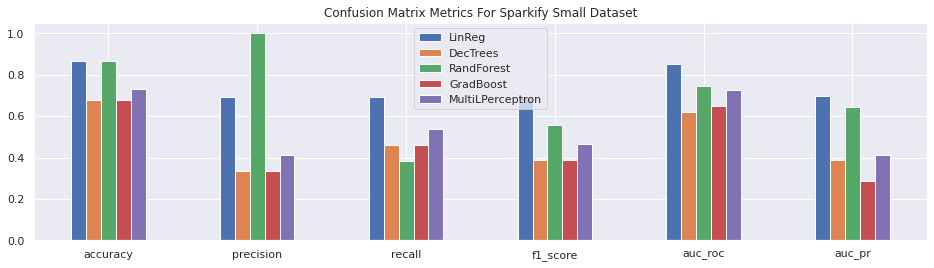

In [54]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,4)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["LinReg", "DecTrees", "RandForest", "GradBoost", "MultiLPerceptron"], rot=0)

# create title and labels
plt.title("Confusion Matrix Metrics For Sparkify Small Dataset")
ax.set_xlabel("");
ax.set_ylabel("");